In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pyodbc
import warnings
warnings.filterwarnings('ignore')

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=DESKTOP-MM8GEH1;'
    'DATABASE=DW_SAP (1);'
    'UID=sa;'
    'PWD=1234'
)
df = pd.read_sql(
    'SELECT Supplier_ID, Supplier_Name, Environmental_Certifications, Sustainability_Program FROM [Dim_Suppliers]',
    conn
)
print("Données chargées :", df.shape)
# Interprétation : vérification du chargement des données (lignes, colonnes)


OperationalError: ('08001', "[08001] [Microsoft][ODBC Driver 17 for SQL Server]Fournisseur de canaux nommés : Impossible d'ouvrir une connexion à SQL Server [2].  (2) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Délai d'attente de connexion expiré (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Une erreur liée au réseau ou spécifique à l'instance s'est produite lors de l'établissement d'une connexion à SQL Server. Le serveur est introuvable ou n'est pas accessible. Vérifiez si le nom de l'instance est correct et si SQL Server est configuré pour autoriser les connexions distantes. Pour plus d'informations, consultez la documentation en ligne de SQL Server. (2)")

In [ ]:
cert_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cert_encoded = cert_encoder.fit_transform(df[['Environmental_Certifications']])
cert_df = pd.DataFrame(
    cert_encoded,
    columns=cert_encoder.get_feature_names_out(['Environmental_Certifications']),
    index=df.index
)
# Interprétation : transformation des certifications en variables indicatrices (0/1)


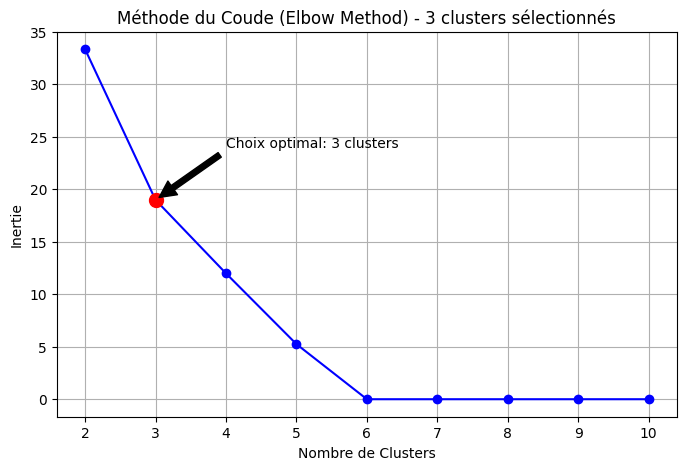

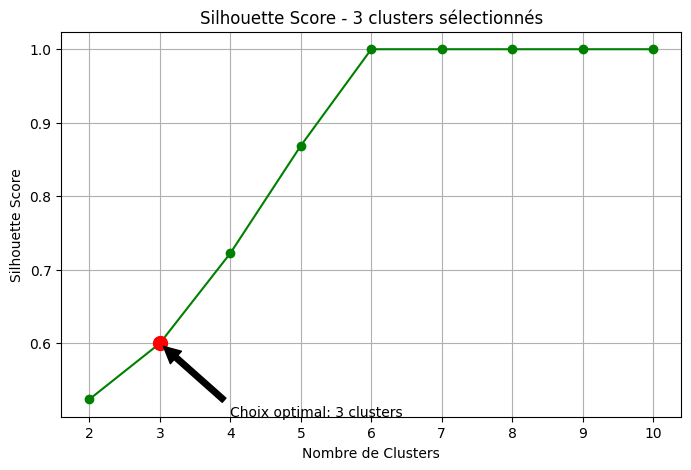

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import matplotlib.pyplot as plt

# Garder uniquement les certifications valides
valid_certifications = ['ISO 14001', 'Agriculture Biologique', 'Aucune']
df = df[df['Environmental_Certifications'].isin(valid_certifications)]

# Encodage
df['Cert_encoded'] = LabelEncoder().fit_transform(df['Environmental_Certifications'])
df['Prog_encoded'] = LabelEncoder().fit_transform(df['Sustainability_Program'])

# Préparer les données pour le clustering
X = df[['Cert_encoded', 'Prog_encoded']]

# Méthode Elbow pour déterminer le nombre optimal de clusters
inertia = []
silhouette_scores = []

for k in range(2, 11):  # Tester de 2 à 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Visualisation de la méthode Elbow avec mise en évidence de 3 clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', color='blue')
plt.plot(3, inertia[1], marker='o', markersize=10, color='red')  # Point pour 3 clusters
plt.title("Méthode du Coude (Elbow Method) - 3 clusters sélectionnés")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inertie")
plt.grid(True)
plt.annotate('Choix optimal: 3 clusters', 
             xy=(3, inertia[1]), 
             xytext=(4, inertia[1]+5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig('elbow_method_3clusters.png')
plt.show()

# Visualisation du Silhouette Score avec mise en évidence de 3 clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.plot(3, silhouette_scores[1], marker='o', markersize=10, color='red')  # Point pour 3 clusters
plt.title("Silhouette Score - 3 clusters sélectionnés")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.annotate('Choix optimal: 3 clusters',
             xy=(3, silhouette_scores[1]),
             xytext=(4, silhouette_scores[1]-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig('silhouette_score_3clusters.png')
plt.show()

# Définir explicitement le nombre optimal de clusters à 3 pour correspondre aux certifications
optimal_clusters = 3

# Clustering avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
df['Cluster'] = kmeans.fit_predict(X)

# Associer les labels aux clusters
cluster_labels = {}
for i in range(optimal_clusters):
    mode_cert = df[df['Cluster'] == i]['Environmental_Certifications'].mode()[0]
    cluster_labels[i] = mode_cert

df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Compter les fournisseurs par cluster
cluster_counts = df['Cluster_Label'].value_counts().reset_index()
cluster_counts.columns = ['Certification', 'Nombre de Fournisseurs']

# Visualisation dynamique avec Plotly
fig = px.bar(
    cluster_counts,
    x='Certification',
    y='Nombre de Fournisseurs',
    text='Nombre de Fournisseurs',
    color='Certification',
    title='Nombre de Fournisseurs par Certification (Cluster)',
    hover_data=['Nombre de Fournisseurs']
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Certification', yaxis_title='Nombre de Fournisseurs')
fig.show()

<h3>Pourquoi 3 est un choix optimal ?</h3>

<p><strong>Méthode du Coude (Elbow) :</strong><br>
L'inertie diminue fortement jusqu'à k=3, puis la baisse devient marginale. Cela suggère que 3 clusters capturent l'essentiel de la variance.</p>

<p><strong>Silhouette Score :</strong><br>
Le score de silhouette est élevé pour k=3, indiquant que les clusters sont bien séparés et cohérents en interne.</p>


Données chargées : (99, 4)


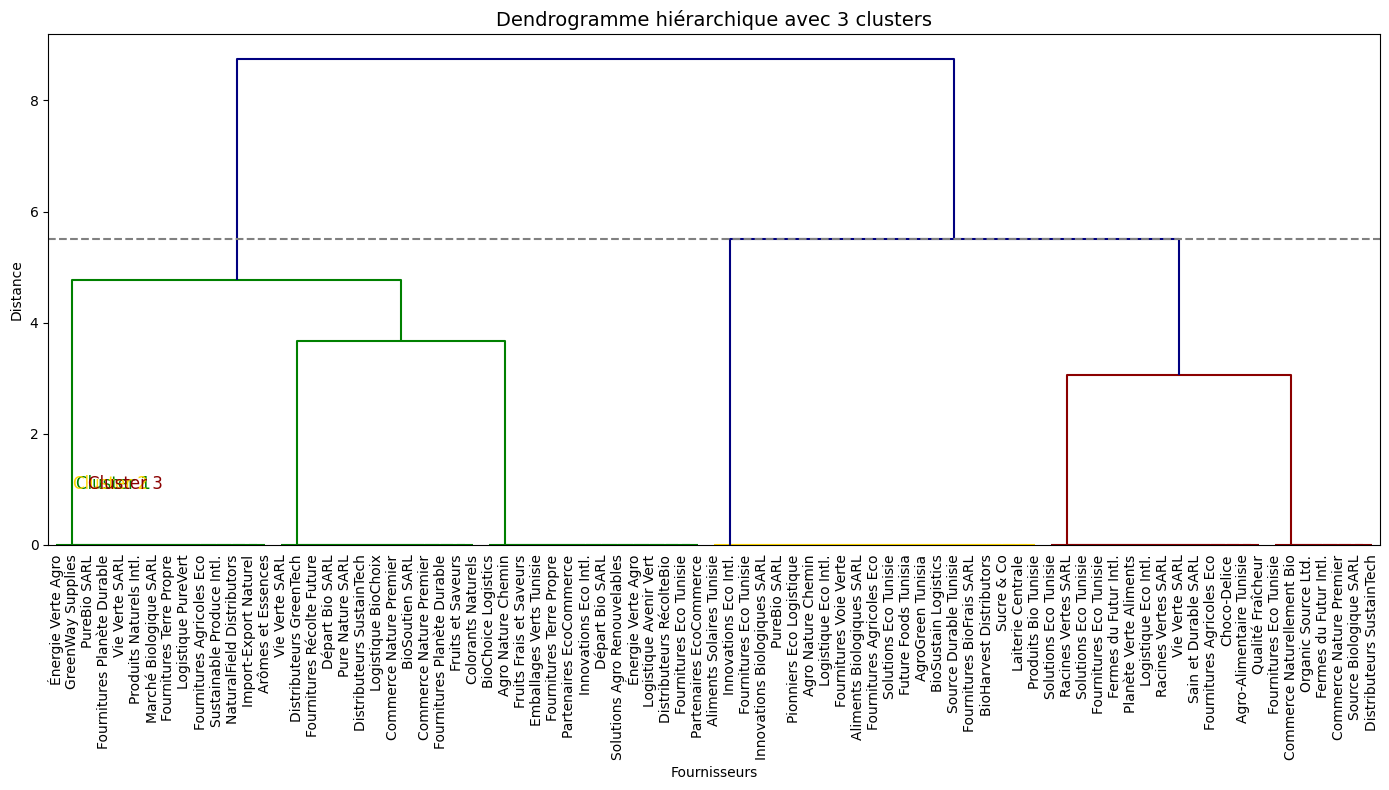

Nombre de clusters créés : 3
Répartition des fournisseurs par cluster: [41 21 21]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
import pyodbc
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Connexion SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=DESKTOP-MM8GEH1;'
    'DATABASE=DW_SAP (1);'
    'UID=sa;PWD=1234'
)

# Chargement et filtrage des données
df = pd.read_sql('''
    SELECT Supplier_ID, Supplier_Name, Environmental_Certifications, Sustainability_Program
    FROM [Dim_Suppliers]
''', conn)
print("Données chargées :", df.shape)

df = df[df['Environmental_Certifications'].isin(['ISO 14001', 'Agriculture Biologique', 'Aucune'])]

# Encodage
df['Cert_encoded'] = LabelEncoder().fit_transform(df['Environmental_Certifications'])
df['Prog_encoded'] = LabelEncoder().fit_transform(df['Sustainability_Program'])

# Clustering hiérarchique
X = df[['Cert_encoded', 'Prog_encoded']]
Z = linkage(X, method='ward')
n_clusters = 3
threshold = Z[-(n_clusters - 1), 2]
df['cluster'] = fcluster(Z, n_clusters, criterion='maxclust')

# Dendrogramme
plt.figure(figsize=(14, 8))
colors = ['green', 'gold', 'darkred']
set_link_color_palette(colors)

dendrogram(
    Z,
    labels=df['Supplier_Name'].values,
    orientation='top',
    color_threshold=threshold,
    above_threshold_color='navy',
    leaf_font_size=10
)
plt.axhline(y=threshold, color='gray', linestyle='--')

# Ajouter les étiquettes des clusters
y_pos = 1.0
for i, color in enumerate(colors, 1):
    indices = np.where(df['cluster'] == i)[0]
    if len(indices):
        plt.text(np.median(indices), y_pos, f"Cluster {i}", fontsize=12, ha='center', color=color)

plt.title('Dendrogramme hiérarchique avec 3 clusters', fontsize=14)
plt.xlabel('Fournisseurs')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogramme_colore.png', dpi=300, bbox_inches='tight')
plt.show()

# Vérifications
print("Nombre de clusters créés :", df['cluster'].nunique())
print("Répartition des fournisseurs par cluster:", df['cluster'].value_counts().sort_index().values)


In [ ]:
import pandas as pd
import numpy as np
import pyodbc
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

# Connexion et chargement
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-MM8GEH1;DATABASE=DW_SAP (1);UID=sa;PWD=1234'
)
df = pd.read_sql('''
    SELECT Supplier_ID, Supplier_Name, Environmental_Certifications, Sustainability_Program
    FROM [Dim_Suppliers]
''', conn)

# Nettoyage et encodage
df['Environmental_Certifications'] = df['Environmental_Certifications'].astype(str).str.strip().str.title()
df = df[~df['Environmental_Certifications'].isin(['2005', '2015', 'Fssc 22000', '20 052 015', '', 'Nan'])]
if df.empty: raise ValueError("Le DataFrame est vide après le filtrage.")

df['Cert_encoded'] = LabelEncoder().fit_transform(df['Environmental_Certifications'])
df['Prog_encoded'] = LabelEncoder().fit_transform(df['Sustainability_Program'])
X = df[['Cert_encoded', 'Prog_encoded']]

# DBSCAN auto
for eps in np.arange(0.1, 2.0, 0.05):
    labels = DBSCAN(eps=eps, min_samples=2).fit_predict(X)
    if (n := len(set(labels)) - (1 if -1 in labels else 0)) >= 2:
        df['Cluster'] = labels
        break
else:
    raise ValueError("Aucun clustering valable trouvé.")

# Étiquettes de cluster
df['Cluster_Label'] = df['Cluster'].apply(
    lambda c: df[df['Cluster'] == c]['Environmental_Certifications'].mode()[0] if c != -1 else "Bruit"
)

# Agrégation et affichage
counts = df[df['Cluster'] != -1]['Cluster_Label'].value_counts().reset_index()
counts.columns = ['Certification', 'Nombre de Fournisseurs']

fig = px.bar(counts, x='Certification', y='Nombre de Fournisseurs', text='Nombre de Fournisseurs',
             color='Certification', title='Nombre de Fournisseurs par Certification (Clusters DBSCAN)')
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Certification', yaxis_title='Nombre de Fournisseurs')
fig.show()


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyodbc
import warnings
warnings.filterwarnings('ignore')

# Connexion SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=DESKTOP-MM8GEH1;'
    'DATABASE=DW_SAP (1);'
    'UID=sa;'
    'PWD=1234'
)

# Chargement des données
df = pd.read_sql(
    'SELECT Supplier_ID, Supplier_Name, Environmental_Certifications, Sustainability_Program FROM [Dim_Suppliers]',
    conn
)

# Nettoyage
valid_certifications = ['ISO 14001', 'Agriculture Biologique', 'Aucune']
df = df[df['Environmental_Certifications'].isin(valid_certifications)]
df['Cert_encoded'] = LabelEncoder().fit_transform(df['Environmental_Certifications'])
df['Prog_encoded'] = LabelEncoder().fit_transform(df['Sustainability_Program'])
X = df[['Cert_encoded', 'Prog_encoded']]

# DBSCAN
def run_dbscan():
    for eps in np.arange(0.1, 2.0, 0.05):
        labels = DBSCAN(eps=eps, min_samples=2).fit_predict(X)
        if (n := len(set(labels)) - (1 if -1 in labels else 0)) >= 2:
            df['Cluster_DBSCAN'] = labels
            break
    df['Cluster_Label_DBSCAN'] = df['Cluster_DBSCAN'].apply(
        lambda c: df[df['Cluster_DBSCAN'] == c]['Environmental_Certifications'].mode()[0] if c != -1 else "Bruit"
    )
    results = df[df['Cluster_DBSCAN'] != -1].groupby('Cluster_Label_DBSCAN')['Environmental_Certifications'].count().reset_index()
    results.columns = ['Certification', 'DBSCAN']
    
    accuracy = np.mean(df[df['Cluster_DBSCAN'] != -1]['Cluster_Label_DBSCAN'] == df[df['Cluster_DBSCAN'] != -1]['Environmental_Certifications']) * 100
    return results, accuracy

# CAH
def run_cah():
    Z = linkage(X, method='ward')
    n_clusters = 3
    df['Cluster_CAH'] = fcluster(Z, n_clusters, criterion='maxclust')
    df['Cluster_Label_CAH'] = df['Cluster_CAH'].apply(
        lambda c: df[df['Cluster_CAH'] == c]['Environmental_Certifications'].mode()[0]
    )
    results = df.groupby('Cluster_Label_CAH')['Environmental_Certifications'].count().reset_index()
    results.columns = ['Certification', 'CAH']
    
    accuracy = np.mean(df['Cluster_Label_CAH'] == df['Environmental_Certifications']) * 100
    return results, accuracy

# KMeans
def run_kmeans():
    kmeans = KMeans(n_clusters=3, random_state=0)
    df['Cluster_KMeans'] = kmeans.fit_predict(X)
    df['Cluster_Label_KMeans'] = df['Cluster_KMeans'].apply(
        lambda c: df[df['Cluster_KMeans'] == c]['Environmental_Certifications'].mode()[0]
    )
    results = df.groupby('Cluster_Label_KMeans')['Environmental_Certifications'].count().reset_index()
    results.columns = ['Certification', 'K-Means']
    
    accuracy = np.mean(df['Cluster_Label_KMeans'] == df['Environmental_Certifications']) * 100
    return results, accuracy

# Exécution
dbscan_results, acc_dbscan = run_dbscan()
cah_results, acc_cah = run_cah()
kmeans_results, acc_kmeans = run_kmeans()

# Fusion
comparison_df = pd.DataFrame({'Certification': valid_certifications})
comparison_df = comparison_df.merge(dbscan_results, on='Certification', how='left')
comparison_df = comparison_df.merge(cah_results, on='Certification', how='left')
comparison_df = comparison_df.merge(kmeans_results, on='Certification', how='left')
comparison_df = comparison_df.fillna(0)

# Ajout des précisions
precision_df = pd.DataFrame({
    'Certification': ['Précision (%)'],
    'DBSCAN': [round(acc_dbscan, 2)],
    'CAH': [round(acc_cah, 2)],
    'K-Means': [round(acc_kmeans, 2)]
})
comparison_df = pd.concat([comparison_df, precision_df], ignore_index=True)

# Visualisation comparative
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('Répartition par méthode de clustering', 
                                    'Comparaison des résultats'),
                    specs=[[{"type": "xy"}],
                           [{"type": "domain"}]])

colors = px.colors.qualitative.Plotly
for i, method in enumerate(['DBSCAN', 'CAH', 'K-Means']):
    fig.add_trace(
        go.Bar(
            x=comparison_df['Certification'][:-1],
            y=comparison_df[method][:-1],
            name=method,
            marker_color=colors[i],
            text=comparison_df[method][:-1],
            textposition='auto'
        ),
        row=1, col=1
    )

# Tableau de comparaison
fig.add_trace(
    go.Table(
        header=dict(values=['Certification', 'DBSCAN', 'CAH', 'K-Means'],
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[comparison_df['Certification'], 
                           comparison_df['DBSCAN'], 
                           comparison_df['CAH'], 
                           comparison_df['K-Means']],
                   fill_color='lavender',
                   align='left')),

    row=2, col=1
)

fig.update_layout(
    height=800,
    title_text="Comparaison des méthodes de clustering avec précision",
    showlegend=True,
    barmode='group'
)

fig.show()

